In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

list_pids = ["INS-W_335", 
             "INS-W_336",
             "INS-W_344",
             "INS-W_360",
             "INS-W_427",
             "INS-W_504",
             "INS-W_508",
             "INS-W_518",
             "INS-W_537",
             "INS-W_541",
             "INS-W_698",
             "INS-W_701",
             "INS-W_744",
             "INS-W_746",
             "INS-W_751",
             "INS-W_913",
             "INS-W_974",
             "INS-W_991",
             "INS-W_1000",
             "INS-W_1031",
             "INS-W_1038",
             "INS-W_1081",
             ]



def find_pid_folder(pid: str, data_root: str = "data/globem_raw/") -> str:
    """
    Given a pid (e.g., 'INS-W_541'), determine which INS-W folder it belongs to.

    Args:
        pid (str): The participant ID to search for.
        data_root (str): Base directory where INS-W_1, INS-W_2, etc. are stored.

    Returns:
        str: The folder name (e.g., 'INS-W_2') if found.

    Raises:
        FileNotFoundError: If the PID is not found in any folder.
    """
    for folder in ["INS-W_1", "INS-W_2", "INS-W_3", "INS-W_4"]:
        label_path = os.path.join(data_root, folder, "SurveyData", "dep_weekly.csv")
        if os.path.exists(label_path):
            df = pd.read_csv(label_path)
            if pid in df["pid"].values:
                return folder
    raise FileNotFoundError(f"PID {pid} not found in any INS-W folder.")

def load_subject_tables(pid: str, folder: str, data_root: str = "data/globem_raw/"):
    """
    Loads and filters the features and labels for a given subject.

    Args:
        pid (str): Participant ID (e.g., 'INS-W_541')
        folder (str): INS-W folder name (e.g., 'INS-W_2') as returned by `find_pid_folder()`
        data_root (str): Base directory for GLOBEM data.

    Returns:
        tuple: (pid_features_df, pid_labels_df)
    """
    # Read feature and label files
    features_path = os.path.join(data_root, folder, "FeatureData", "rapids.csv")
    labels_path = os.path.join(data_root, folder, "SurveyData", "dep_weekly.csv")

    features_df = pd.read_csv(features_path)
    labels_df = pd.read_csv(labels_path)

    # Filter labels
    labels_df = labels_df.loc[labels_df["pid"] == pid].drop(columns=["Unnamed: 0"], errors='ignore')

    # Filter features: keep only certain types, exclude others
    pid_features_df = features_df.loc[
        features_df["pid"] == pid,
        features_df.columns.str.contains(r"^(f_slp:fitbit|f_screen:phone|f_steps:fitbit|pid|date)")
        & ~features_df.columns.str.contains(r"(14dhist|7dhist|_dis:|_norm:|weekday|weekend)")
    ]

    return pid_features_df, labels_df


def plot_sleep_and_phq4(pid_features_df: pd.DataFrame, pid_labels_df: pd.DataFrame, pid: str = None, save_df = False):
    """
    Plot first bedtime and first wake time alongside PHQ4 scores for a subject.

    Args:
        pid_features_df (pd.DataFrame): Filtered feature dataframe for one subject.
        pid_labels_df (pd.DataFrame): Filtered label dataframe for one subject.
        pid (str, optional): PID to show in the plot title (optional).
    """
    # Feature names to use
    features_to_plot = {
        "bed": "f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday",
        "wake": "f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:allday"
    }

    # Merge features with PHQ4 scores on date
    merged_df = pd.merge(
        pid_features_df[["date"] + list(features_to_plot.values())],
        pid_labels_df[["date", "phq4"]],
        on="date",
        how="left"
    )

    # Ensure datetime
    merged_df["date"] = pd.to_datetime(merged_df["date"])

    # Convert to hours after midnight
    merged_df["first_bed_hr"] = merged_df[features_to_plot["bed"]] / 60
    merged_df["first_wake_hr"] = merged_df[features_to_plot["wake"]] / 60

    # Sort for time series plotting
    merged_df = merged_df.sort_values("date")

    if save_df:
        merged_df.to_csv(f"data/processed/{pid}_features_labels.csv", index=False)

    # Create figure
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot sleep features
    ax1.plot(merged_df["date"], merged_df["first_bed_hr"], marker='o', label="First Bedtime (hr)")
    ax1.plot(merged_df["date"], merged_df["first_wake_hr"], marker='o', label="First Wake Time (hr)")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Sleep Time (hours after midnight)")

    # Tick labels only on PHQ4 dates
    phq4_dates = merged_df.loc[merged_df["phq4"].notna(), "date"]
    ax1.set_xticks(phq4_dates)
    ax1.set_xticklabels(phq4_dates.dt.strftime('%Y-%m-%d'), rotation=45)

    # Plot PHQ4 scores on secondary y-axis
    ax2 = ax1.twinx()
    phq4_series = merged_df[["date", "phq4"]].dropna().sort_values("date")
    ax2.plot(phq4_series["date"], phq4_series["phq4"], color='black', marker='s', linestyle='--', label='PHQ4 Score')
    ax2.set_ylabel("PHQ4 Score")

    # Set y-limits for clarity
    y_min = int(np.floor(merged_df["first_wake_hr"].min()))
    y_max = int(np.floor(merged_df["first_bed_hr"].max()) + 1)
    y_ticks = list(range(y_min, y_max))  # 4 to 30 inclusive
    y_tick_labels = [str(tick if tick < 24 else tick - 24) for tick in y_ticks]
    y_tick_labels = [str(tick if tick >= 0 else tick + 24) for tick in y_ticks]

    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_tick_labels)

    ax1.set_ylabel("Sleep Time (hours)")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    # Title
    title = f"First Bedtime / Wake Time and PHQ4 over Time"
    if pid is not None:
        title += f" (PID: {pid})"
    plt.title(title)

    plt.tight_layout()
    plt.show()


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("data/processed/phq4_ts_features.csv")

# 1) Per-feature missing counts (optional)
missing_per_feature = df.isna().sum()
print("Missing cells per feature:")
display(missing_per_feature.to_frame(name="missing_count"))

# 2) Per-subject × per-feature missing counts
missing_matrix = df.groupby("pid").apply(lambda g: g.isna().sum())

# If 'pid' became a column in the result, drop it
missing_matrix = missing_matrix.drop(columns=["pid"], errors="ignore")

# Display the full matrix
print("\nMissing cells per subject and feature:")
display(missing_matrix)

Missing cells per feature:


,missing_count
pid,0
PHQ4_date,0
PHQ4,0
Days,0
SRI,112
IS,112
sigma_bed,112
mid_sleep,112
dlmo_proxy,112
f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night_mean,33



Missing cells per subject and feature:


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/1841597273.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_matrix = df.groupby("pid").apply(lambda g: g.isna().sum())


,PHQ4_date,PHQ4,Days,SRI,IS,sigma_bed,mid_sleep,dlmo_proxy,f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night_mean,f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night_std,f_screen:phone_screen_rapids_sumdurationunlock:night_mean,f_screen:phone_screen_rapids_sumdurationunlock:night_std,f_screen:phone_screen_rapids_sumdurationunlock:allday_mean,f_screen:phone_screen_rapids_sumdurationunlock:allday_std,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:allday_mean,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:allday_std,f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:allday_mean,f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:allday_std,f_steps:fitbit_steps_intraday_rapids_sumsteps:allday_mean,f_steps:fitbit_steps_intraday_rapids_sumsteps:allday_std
pid,,,,,,,,,,,,,,,,,,,,
INS-W_1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_1004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_1006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INS-W_994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
INS-W_996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
df_clean = df.dropna(axis=0, how='any')
(df_clean["pid"].value_counts() > 6).sum()

np.int64(493)

# Example subject plots

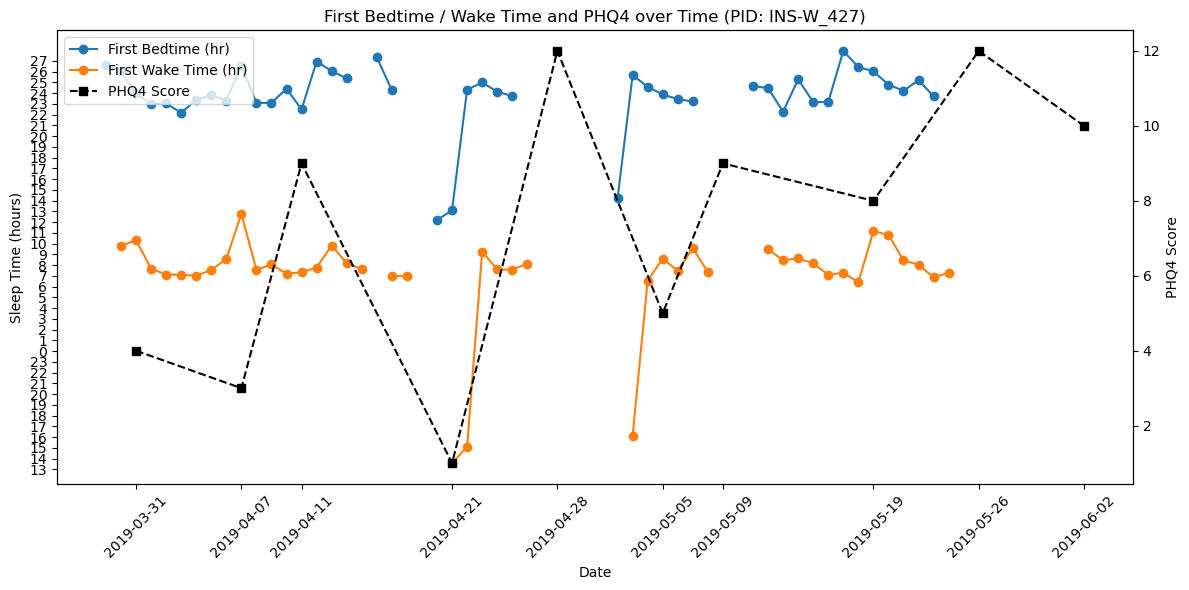

In [39]:
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

In [70]:
pid_features_df.loc[:, "f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday"].notna().sum()

np.int64(0)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/3406277927.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,22

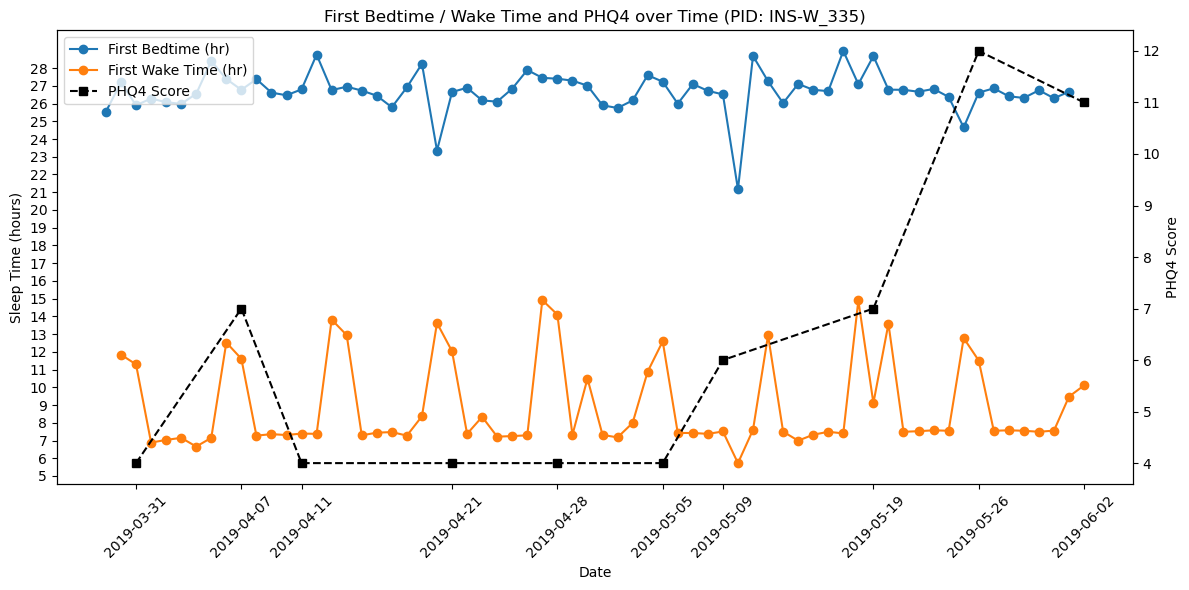

In [62]:
index = 0
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid, save_df=True)

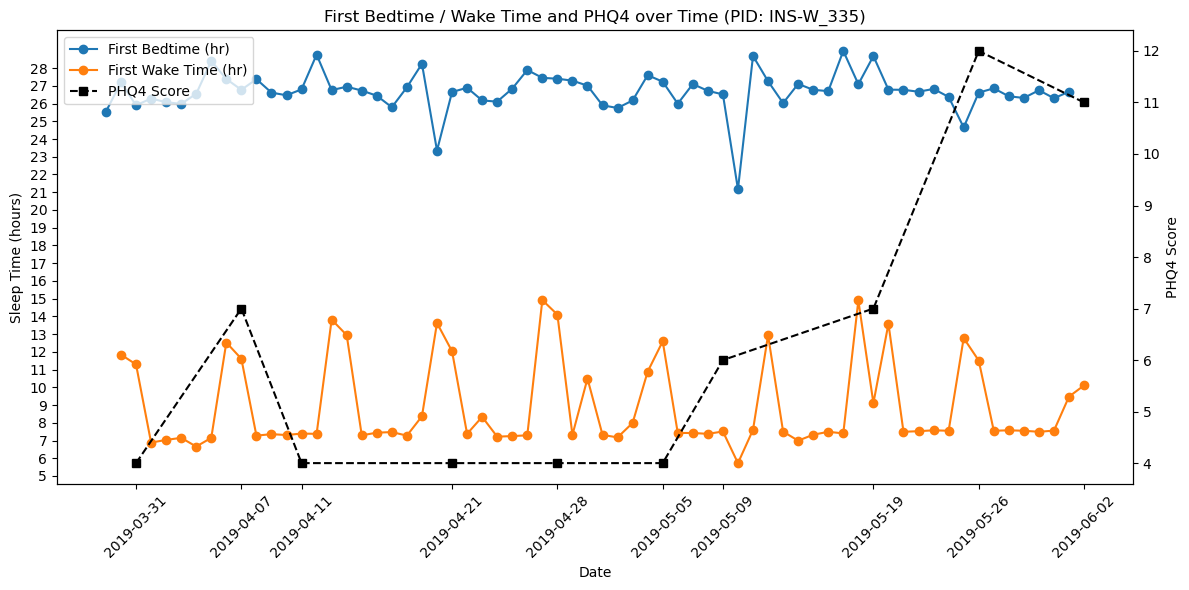

In [58]:
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid, save_df=True)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/357394554.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

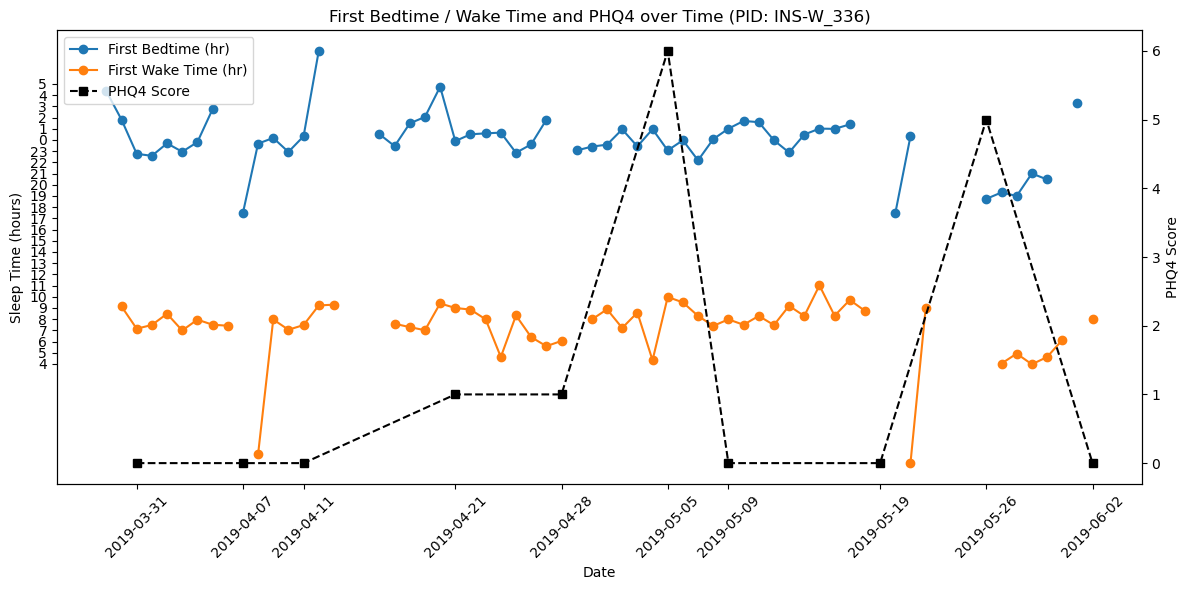

In [72]:
pid_features_df.loc[:, "f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday"].notna().sum()


np.int64(65)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/3406277927.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,22

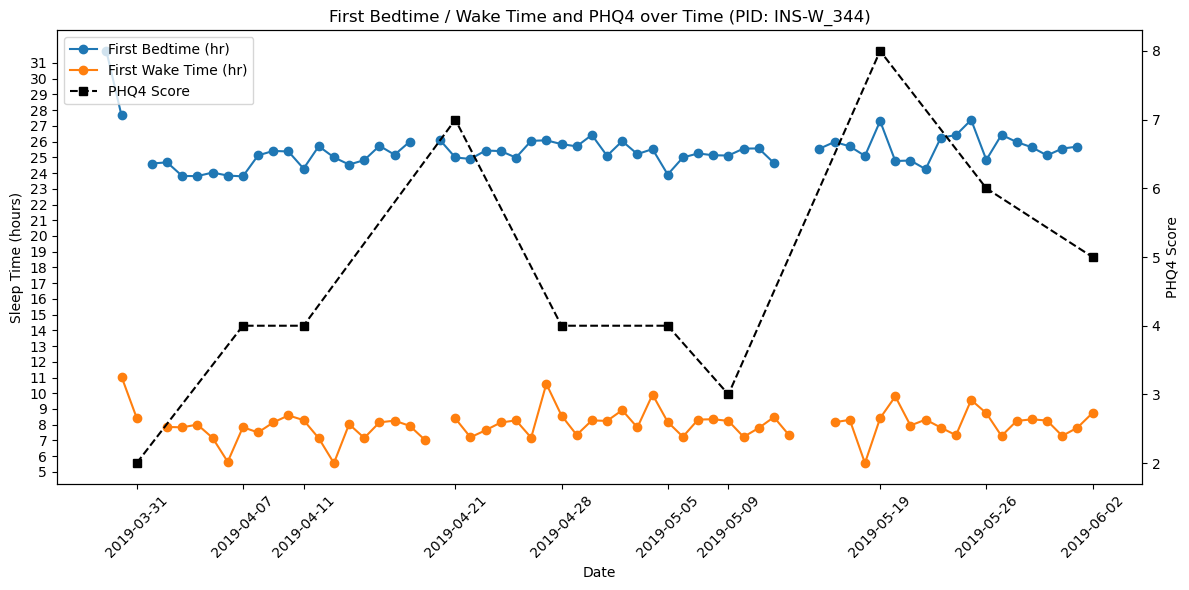

In [71]:
index = 2
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
pid_features_df.loc[:, "f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday"].notna().sum()
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/1439005198.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,22

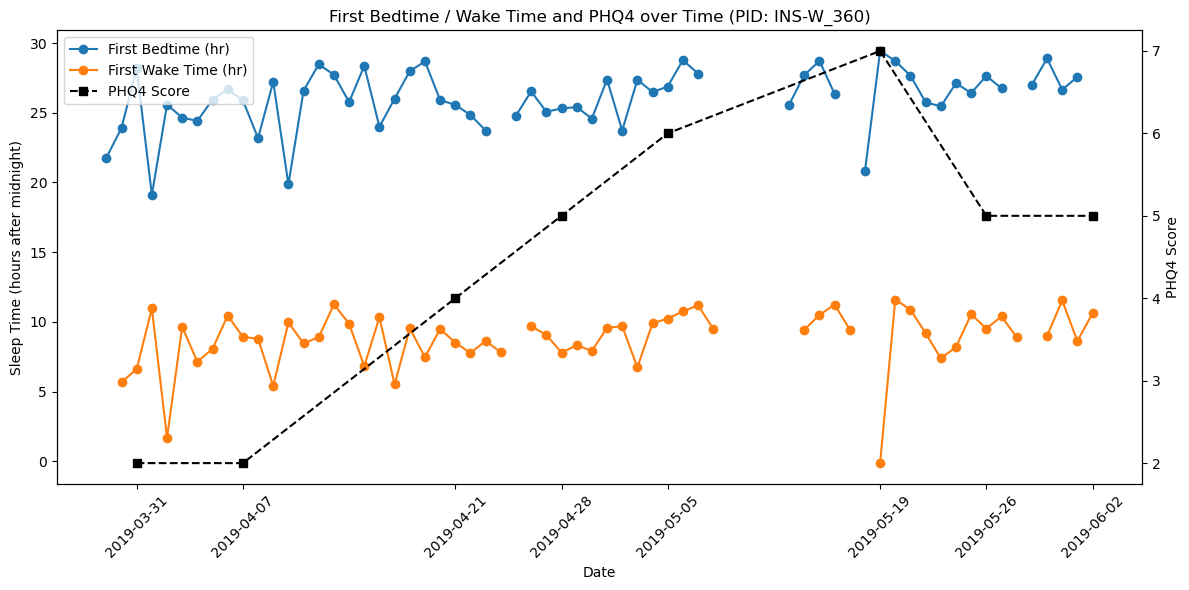

In [23]:
index = 3
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/415550633.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

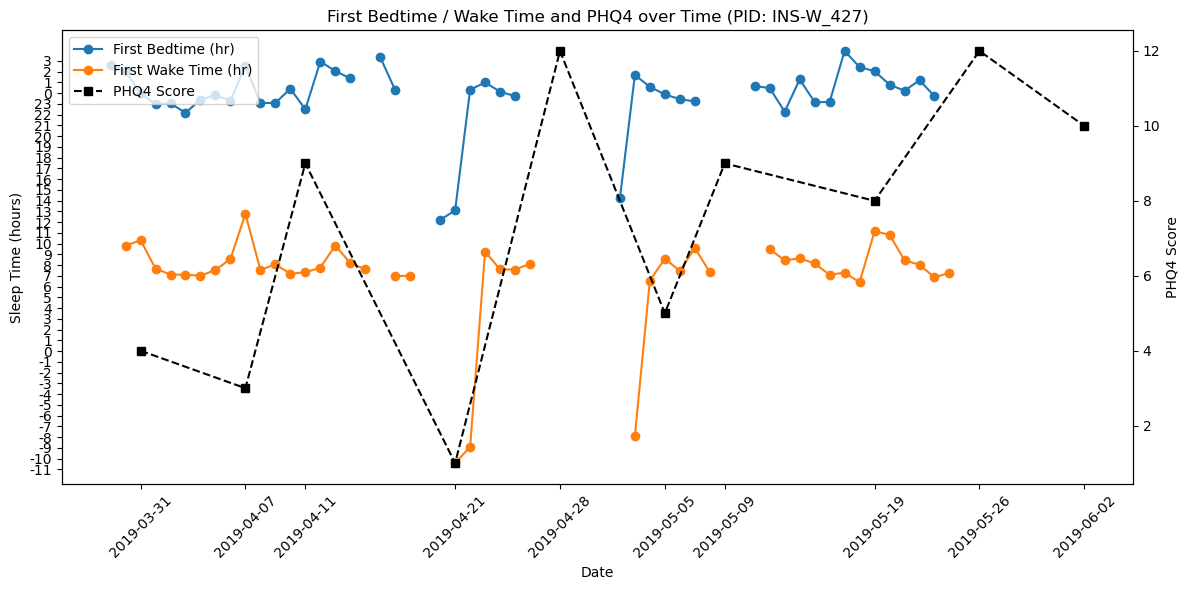

In [37]:
index = 4
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

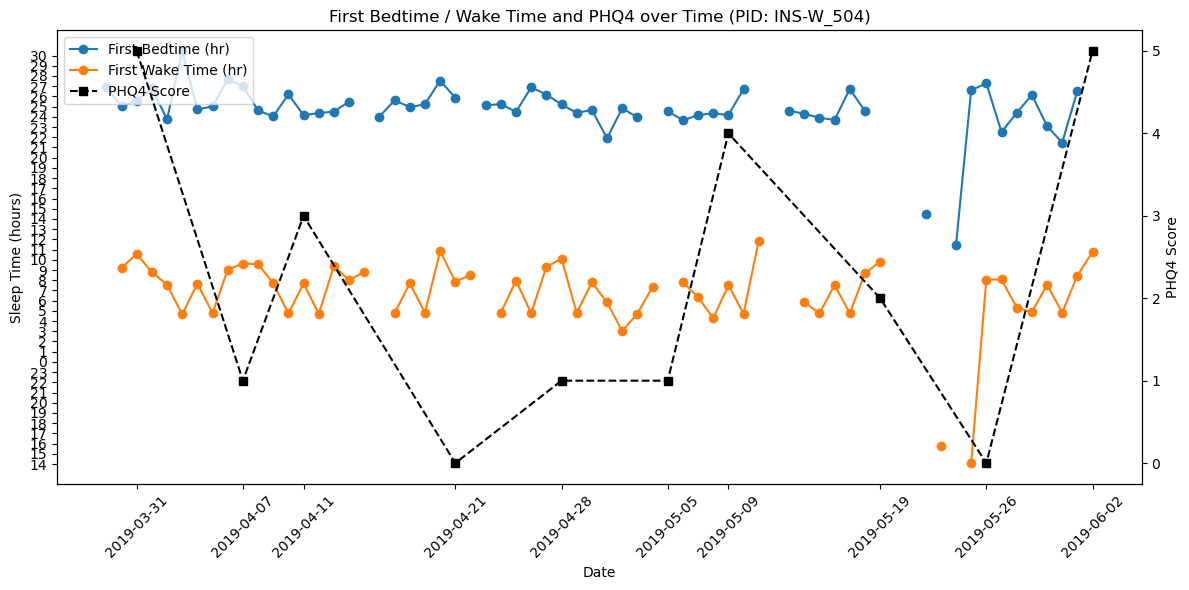

In [40]:
index = 5
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

In [41]:
pid_features_df.to_csv("example_pid_features_df.csv", index=False)
pid_labels_df.to_csv("examine_pid_labels_df.csv", index=False)  

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

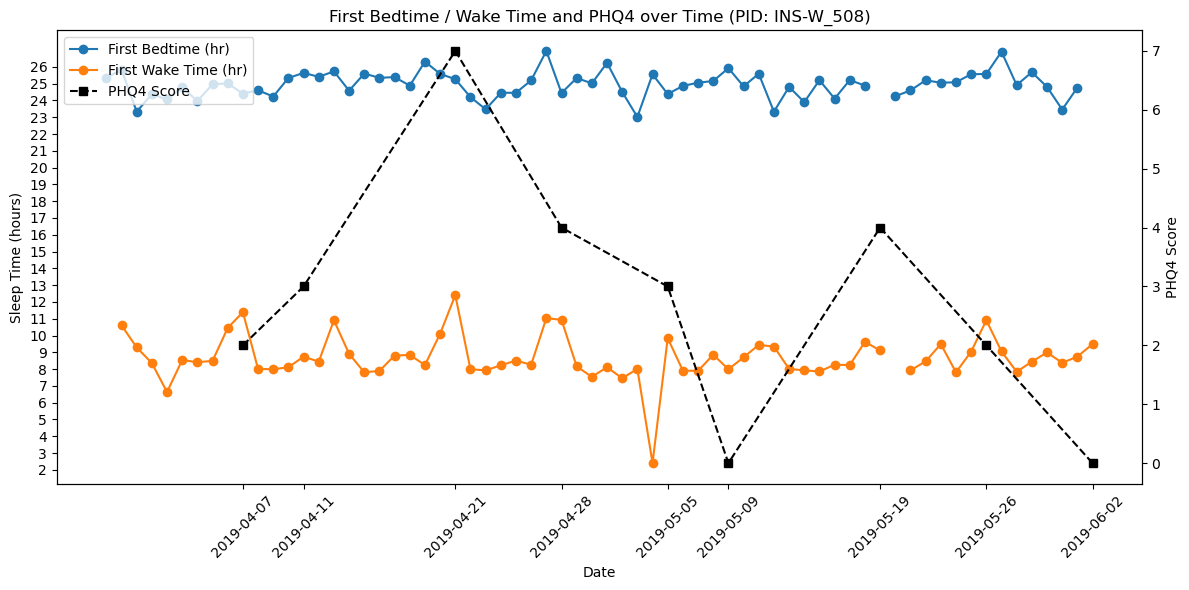

In [42]:
index = 6
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

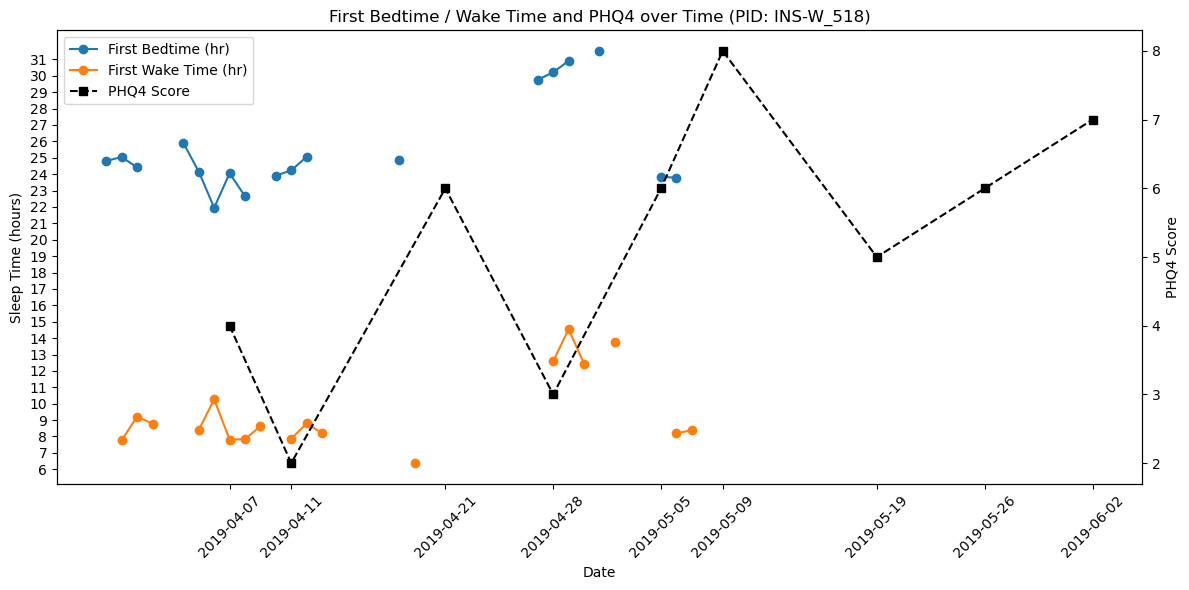

In [43]:
index = 7
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

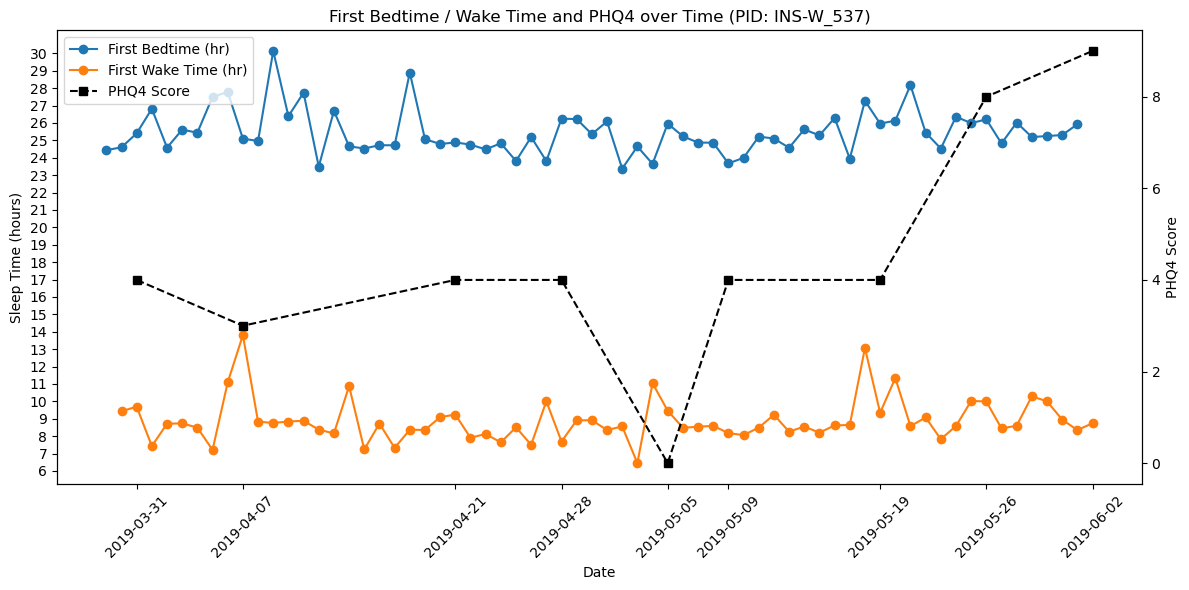

In [44]:
index = 8
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,224

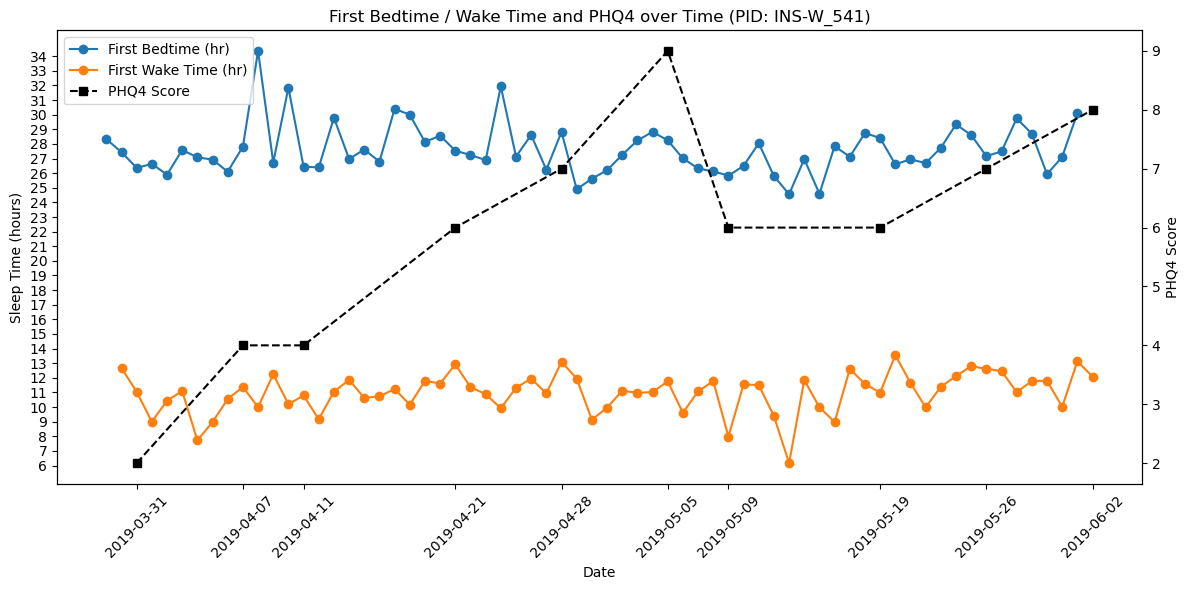

In [45]:
index = 9
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (252,286,296,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,864,876,898,908,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1500,1510,1520,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2100,2112,2122,2132,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,22

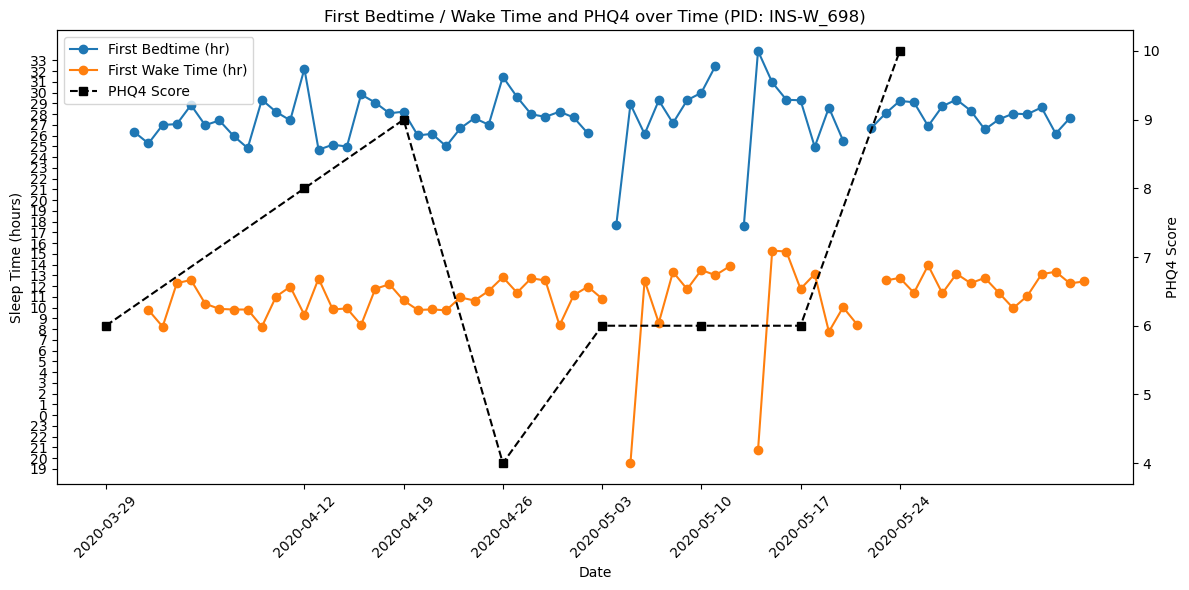

In [46]:
index = 10
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (252,286,296,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,864,876,898,908,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1500,1510,1520,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2100,2112,2122,2132,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,22

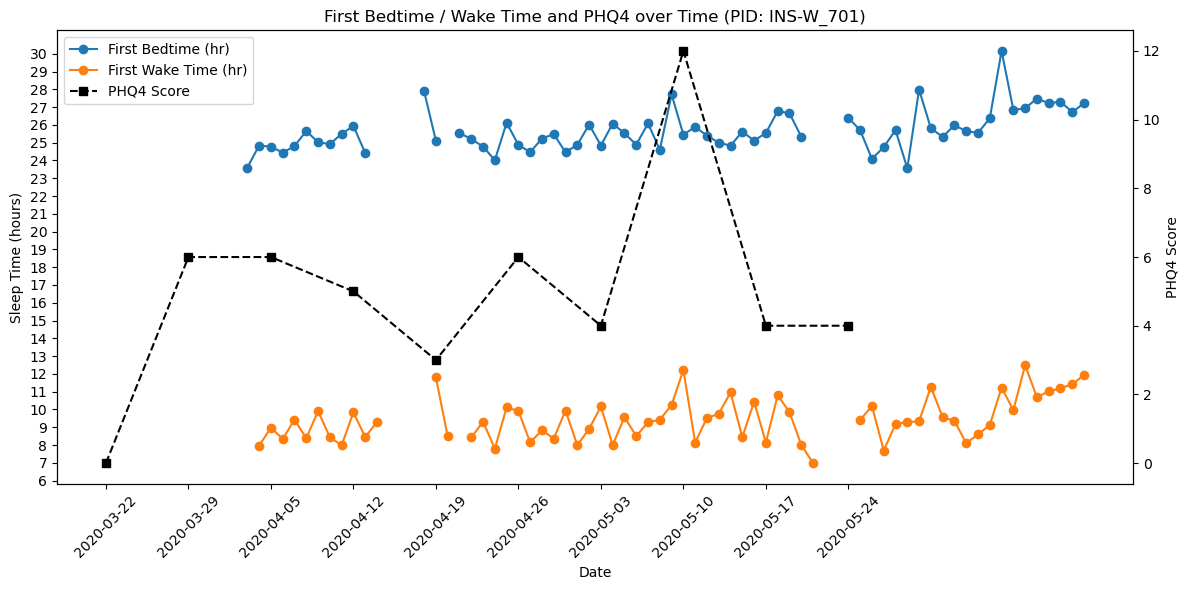

In [47]:
index = 11
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (252,286,296,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,864,876,898,908,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1500,1510,1520,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2100,2112,2122,2132,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,22

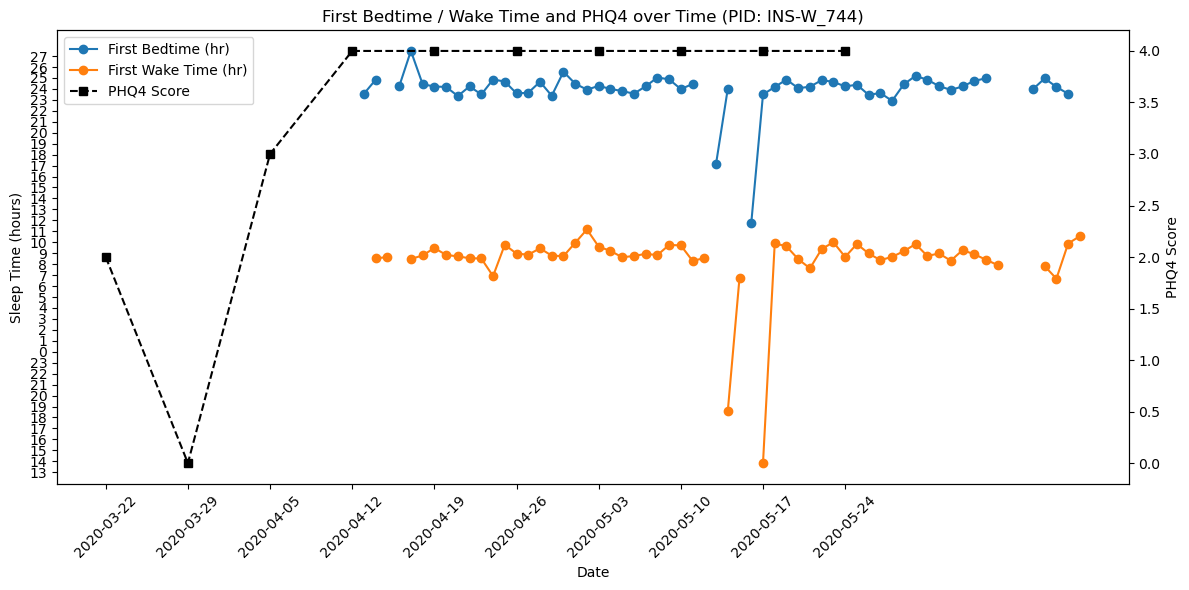

In [48]:
index = 12
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (252,286,296,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,864,876,898,908,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1500,1510,1520,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2100,2112,2122,2132,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,22

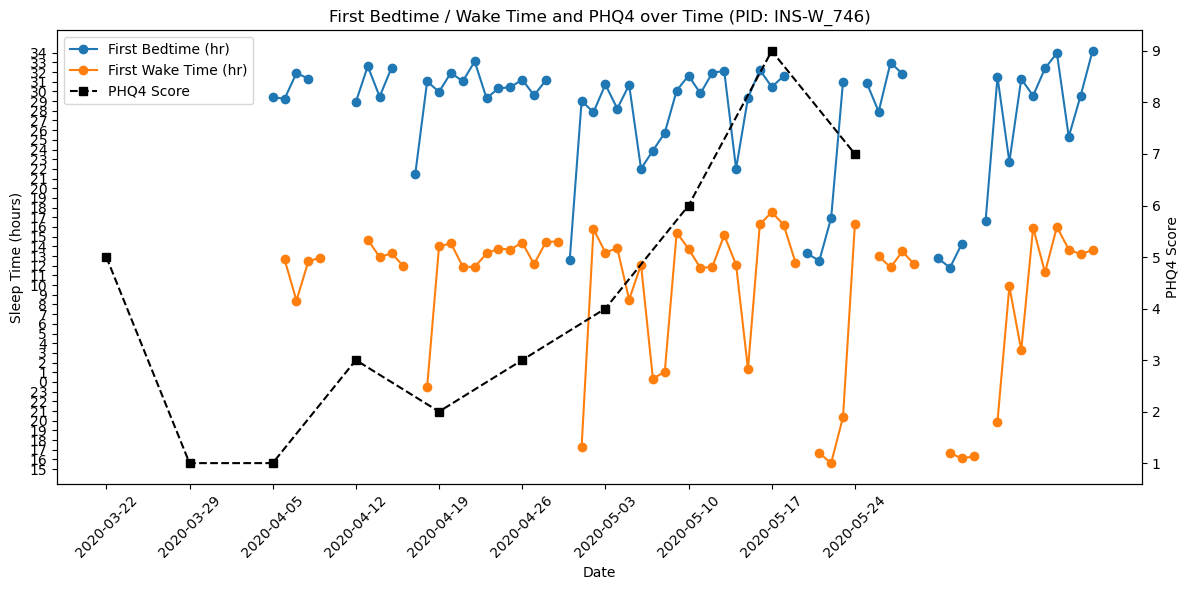

In [49]:
index = 13
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (252,286,296,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,864,876,898,908,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1472,1473,1474,1475,1476,1477,1478,1479,1480,1484,1485,1486,1487,1488,1489,1490,1491,1492,1500,1510,1520,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2100,2112,2122,2132,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,22

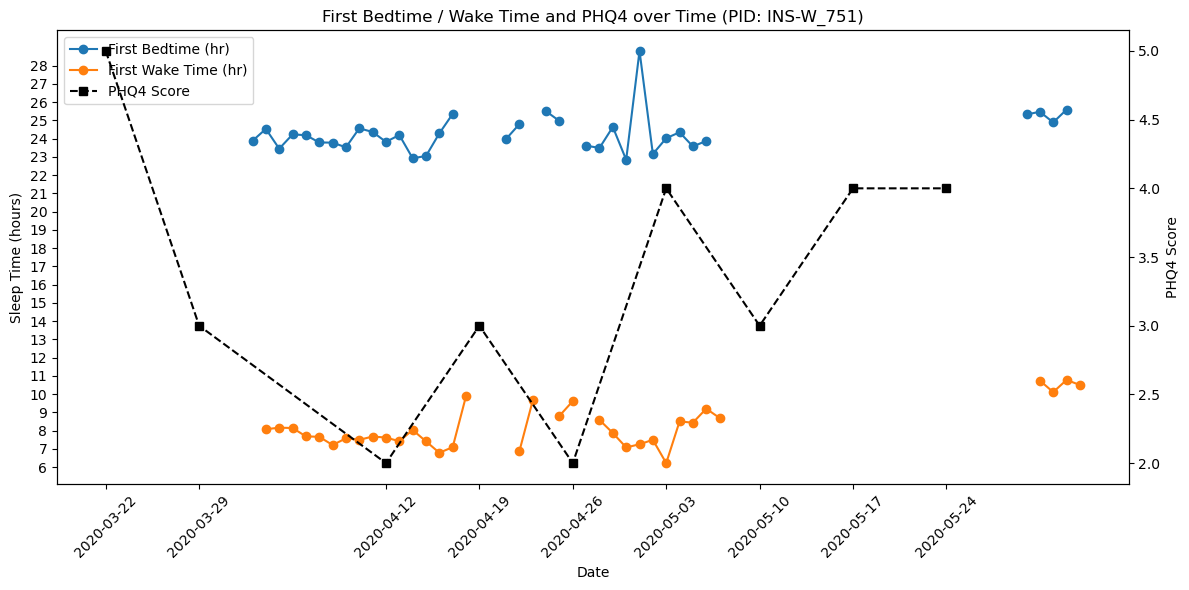

In [50]:
index = 14
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (286,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,898,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1476,1510,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2122,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,26

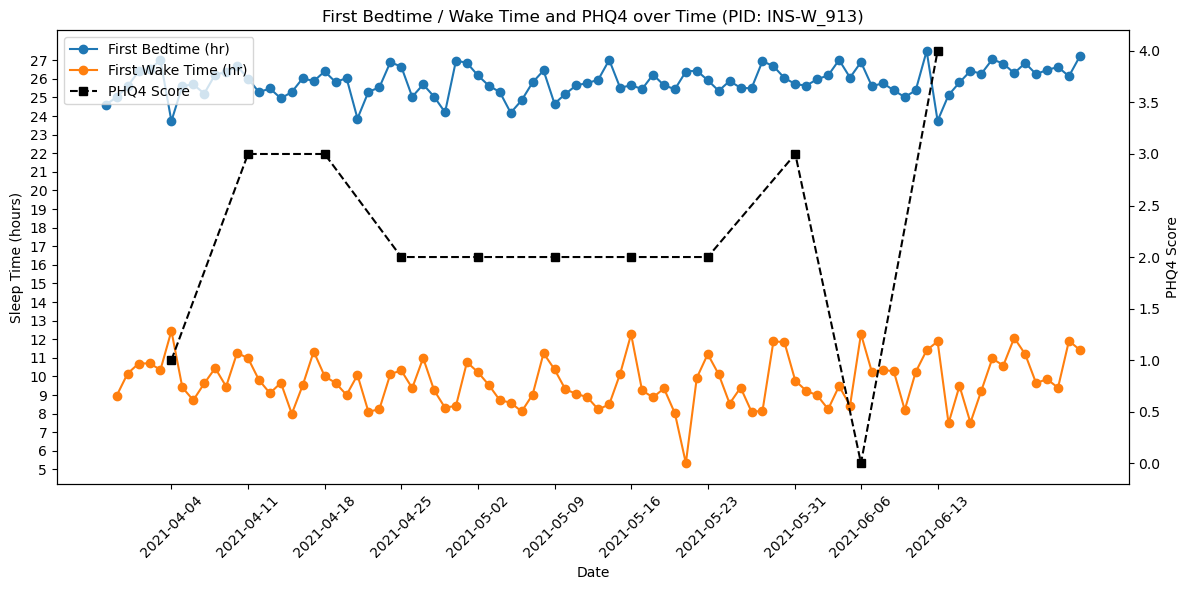

In [51]:
index = 15
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (286,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,898,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1476,1510,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2122,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,26

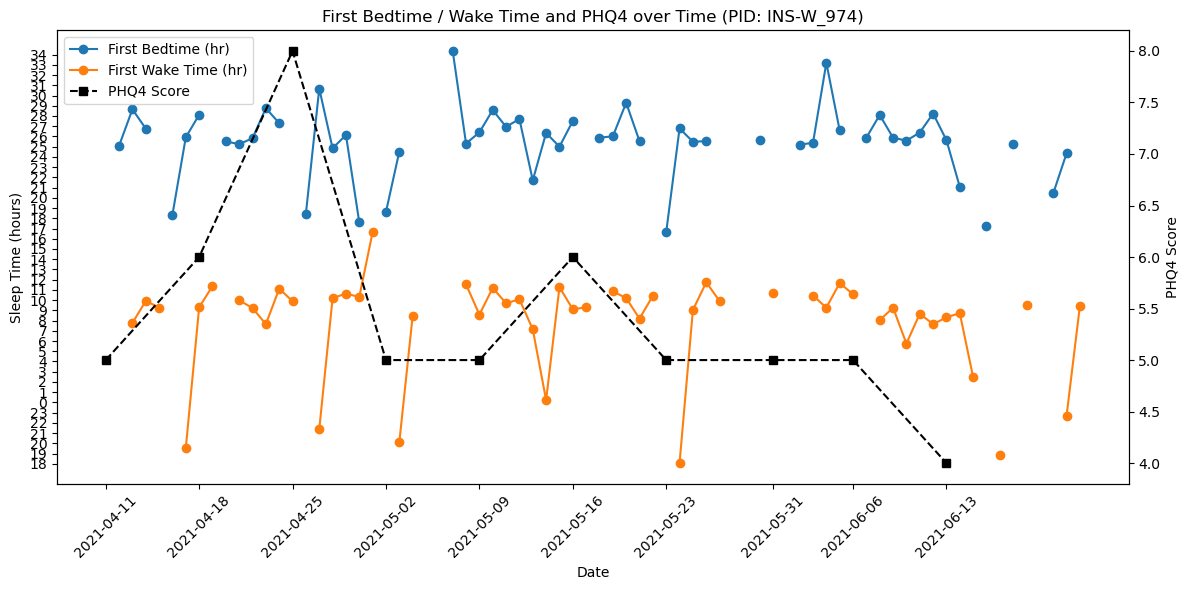

In [52]:
index = 16
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (286,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,898,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1476,1510,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2122,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,26

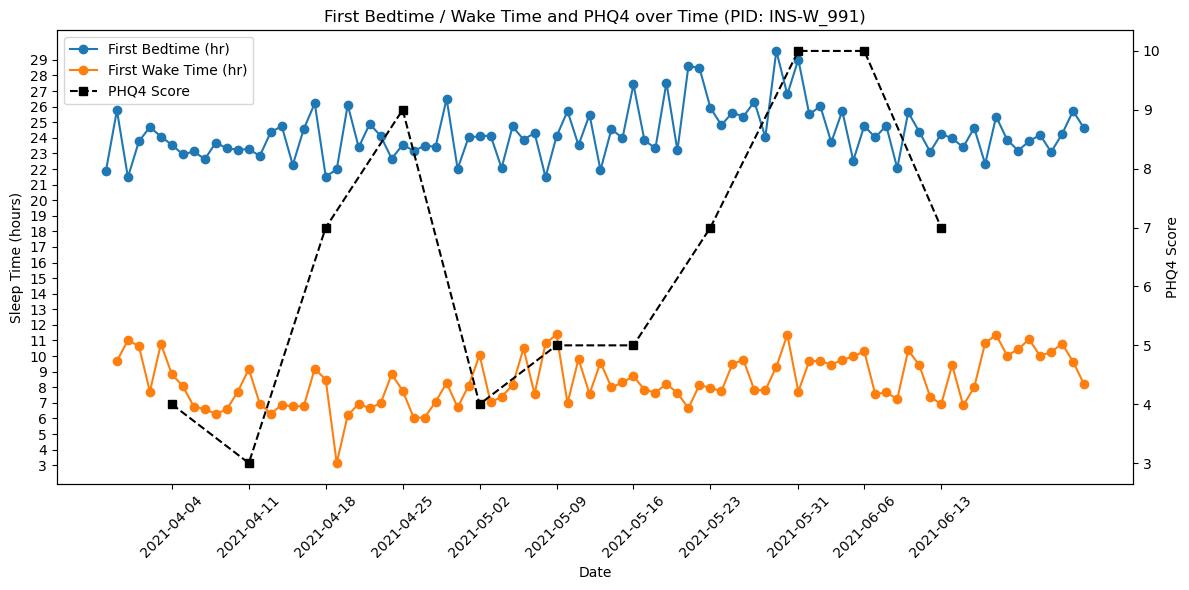

In [53]:
index = 17
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/965666801.py:71: DtypeWarning: Columns (286,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,367,368,369,370,371,372,373,374,375,376,377,378,379,380,898,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,979,980,981,982,983,984,985,986,987,988,989,990,991,992,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1476,1510,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,2088,2122,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2203,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,26

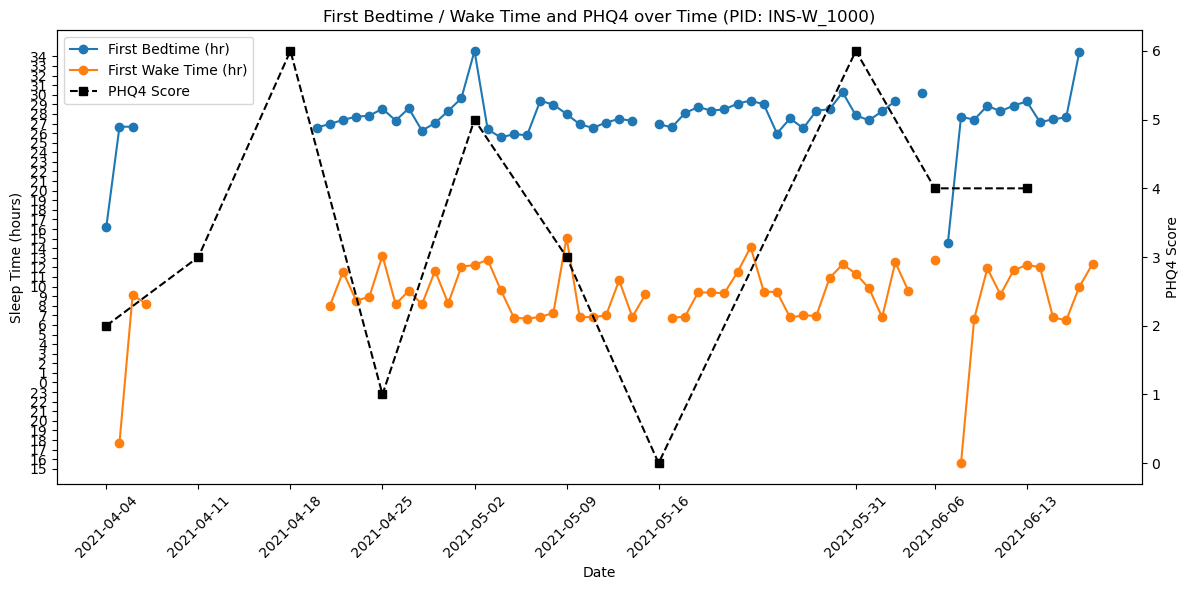

In [54]:
index = 18
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

In [ ]:
index = 19
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

In [ ]:
index = 20
pid = list_pids[index]
folder = find_pid_folder(pid)
pid_features_df, pid_labels_df = load_subject_tables(pid, folder)
plot_sleep_and_phq4(pid_features_df, pid_labels_df, pid=pid)

# metric calculation

In [ ]:
import pandas as pd, numpy as np
from datetime import timedelta, datetime

FILE = "data/processed/INS-W_335_features_labels.csv"
df = pd.read_csv(FILE, parse_dates=["date"])
df = df.dropna(subset=["first_bed_hr", "first_wake_hr"]).copy()

# Pre‑compute mod‑24 clock times
df["bed_mod"]  = df["first_bed_hr"]  % 24
df["wake_mod"] = df["first_wake_hr"] % 24

MINUTES_PER_DAY = 1440

def day_vector(bed, wake):
    """Return a 1440-length binary vector (1 = asleep) for one day."""
    vec = np.zeros(MINUTES_PER_DAY, dtype=int)
    b = int(round(bed * 60)) % MINUTES_PER_DAY
    w = int(round(wake * 60)) % MINUTES_PER_DAY
    if w > b:                   # sleep starts & ends the same calendar day
        vec[b:w] = 1
    else:                       # crosses midnight
        vec[b:] = 1
        vec[:w] = 1
    return vec

def metrics_for_window(win):
    mat = np.stack([day_vector(b, w) for b, w in zip(win["bed_mod"], win["wake_mod"])])
    series = mat.flatten()

    # --- Sleep Regularity Index (Phillips 2017) --------------------
    aligned = series[:-MINUTES_PER_DAY] == series[MINUTES_PER_DAY:]
    sri = 200 * aligned.mean() - 100

    # --- Interdaily Stability (IS) --------------------------------
    grand = series.mean()
    avg24 = mat.mean(axis=0)
    is_val = ((avg24 - grand)**2).sum() / ((series - grand)**2).sum()

    # --- Bed‑time scatter -----------------------------------------
    bed_sd = win["bed_mod"].std()

    # --- Mid‑sleep chronotype -------------------------------------
    mids = []
    for b, w in zip(win["bed_mod"], win["wake_mod"]):
        dur = (w - b) % 24
        mids.append((b + dur / 2) % 24)
    mid_sleep = np.mean(mids)

    dlmo_proxy = (win["bed_mod"].mean() - 2) % 24
    return sri, is_val, bed_sd, mid_sleep, dlmo_proxy

# ------------------------------------------------------------------
# Build windows between successive PHQ‑4 assessments
phq = df[~df["phq4"].isna()].sort_values("date")[["date", "phq4"]]

records = []
for i in range(1, len(phq)):
    start = phq.iloc[i-1]["date"]
    end   = phq.iloc[i]["date"]
    win   = df[(df["date"] >= start) & (df["date"] < end)]
    if len(win) < 2:            # need ≥2 days for SRI
        continue
    sri, is_val, bed_sd, ms, dlmo = metrics_for_window(win)
    records.append({
        "PHQ-4 date": end.date(),
        "PHQ-4": phq.iloc[i]["phq4"],
        "Days": len(win),
        "SRI": round(sri, 1),
        "IS": round(is_val, 3),
        "sigma_bed (h)": round(bed_sd, 2),
        "Mid-sleep (h)": round(ms, 2),
        "DLMO proxy (h)": round(dlmo, 2)
    })

out = pd.DataFrame(records)
out

,PHQ-4 date,PHQ-4,Days,SRI,IS,sigma_bed (h),Mid-sleep (h),DLMO proxy (h)
0,2019-04-07,7.0,7,79.0,0.093,0.92,5.52,0.65
1,2019-04-11,4.0,4,83.3,0.192,0.40,5.60,0.81
2,2019-04-21,4.0,10,70.0,0.058,6.48,5.99,3.07
3,2019-04-28,4.0,7,75.4,0.091,0.64,6.03,0.86
4,2019-05-05,4.0,7,71.5,0.093,0.77,6.03,0.73
5,2019-05-09,6.0,4,77.9,0.181,0.56,5.73,0.76
6,2019-05-19,7.0,10,59.1,0.051,5.74,5.58,3.03
7,2019-05-26,12.0,7,71.9,0.090,1.17,6.03,0.68


In [60]:
import pandas as pd, numpy as np
from datetime import timedelta

def impute_sleep_times(df, bed_col="first_bed_hr", wake_col="first_wake_hr", date_col="date"):
    """
    Linearly interpolate missing bedtime and wake‑time values.
    Forward/Backward fill for leading/trailing NaNs.
    """
    df = df.sort_values(date_col).copy()
    for col in [bed_col, wake_col]:
        df[col] = df[col].interpolate(method="linear", limit_direction="both")
    return df

def day_vector(bed_hr, wake_hr):
    """
    Return a 1440-long binary vector (1=asleep) for a single day,
    given bed & wake time in hours since midnight (mod‑24).
    Handles cross-midnight sleep.
    """
    MINUTES = 1440
    vec = np.zeros(MINUTES, dtype=int)
    b = int(round(bed_hr * 60)) % MINUTES
    w = int(round(wake_hr * 60)) % MINUTES
    if w > b:
        vec[b:w] = 1
    else:
        vec[b:] = 1
        vec[:w] = 1
    return vec

def window_metrics(win_df, bed_col="first_bed_hr", wake_col="first_wake_hr"):
    """Compute SRI, IS, bedtime SD, mid‑sleep, DLMO proxy for a window of days."""
    mats = np.stack([day_vector(b%24, w%24) for b, w in zip(win_df[bed_col], win_df[wake_col])])
    series = mats.flatten()
    MINUTES = 1440
    sri = 200 * (series[:-MINUTES] == series[MINUTES:]).mean() - 100
    grand = series.mean()
    is_val = ((mats.mean(axis=0) - grand)**2).sum() / ((series - grand)**2).sum()
    bed_sd = (win_df[bed_col] % 24).std()
    mids = [((b%24) + ((w-b)%24)/2) % 24 for b, w in zip(win_df[bed_col], win_df[wake_col])]
    mid_sleep = np.mean(mids)
    dlmo_proxy = ((win_df[bed_col] % 24).mean() - 2) % 24
    return sri, is_val, bed_sd, mid_sleep, dlmo_proxy

def circadian_metrics_by_phq_window(df,
                                    bed_col="first_bed_hr",
                                    wake_col="first_wake_hr",
                                    phq_col="phq4",
                                    date_col="date"):
    """
    Impute missing sleep times, then compute circadian metrics
    for each window between consecutive PHQ assessments.
    """
    df = impute_sleep_times(df, bed_col, wake_col, date_col)
    phq = df[~df[phq_col].isna()].sort_values(date_col)[[date_col, phq_col]]
    records = []
    for i in range(1, len(phq)):
        start, end = phq.iloc[i-1][date_col], phq.iloc[i][date_col]
        window = df[(df[date_col] >= start) & (df[date_col] < end)]
        if len(window) < 2:
            continue
        sri, is_val, bed_sd, mid_sleep, dlmo = window_metrics(window, bed_col, wake_col)
        records.append({
            "PHQ_date": end.date(),
            "PHQ": phq.iloc[i][phq_col],
            "Days": len(window),
            "SRI": round(sri, 1),
            "IS": round(is_val, 3),
            "σ_bed(h)": round(bed_sd, 2),
            "Mid_sleep(h)": round(mid_sleep, 2),
            "DLMO_proxy(h)": round(dlmo, 2)
        })
    return pd.DataFrame(records)

# ------------------ Demo on user's CSV ----------------------------
FILE = "data/processed/INS-W_335_features_labels.csv"
data = pd.read_csv(FILE, parse_dates=["date"])
result_table = circadian_metrics_by_phq_window(data)
result_table

,PHQ_date,PHQ,Days,SRI,IS,σ_bed(h),Mid_sleep(h),DLMO_proxy(h)
0,2019-04-07,7.0,7,79.0,0.093,0.92,5.52,0.65
1,2019-04-11,4.0,4,83.3,0.192,0.40,5.60,0.81
2,2019-04-21,4.0,10,70.0,0.058,6.48,5.99,3.07
3,2019-04-28,4.0,7,75.4,0.091,0.64,6.03,0.86
4,2019-05-05,4.0,7,71.5,0.093,0.77,6.03,0.73
5,2019-05-09,6.0,4,77.9,0.181,0.56,5.73,0.76
6,2019-05-19,7.0,10,59.1,0.051,5.74,5.58,3.03
7,2019-05-26,12.0,7,71.9,0.090,1.17,6.03,0.68
8,2019-06-02,11.0,7,88.9,0.118,0.22,5.47,0.56


# Scrap

In [ ]:
index = 0

data_dir = "data/globem_raw/"

features_dir = "data/globem_raw/INS-W_2/FeatureData/rapids.csv"

features_df = pd.read_csv(features_dir)

labels_dir = "data/globem_raw/INS-W_2/SurveyData/dep_weekly.csv"

labels_df = pd.read_csv(labels_dir)

labels_df = labels_df.loc[labels_df["pid"].eq(list_pids[index]),:]
labels_df = labels_df.drop(columns=["Unnamed: 0"], axis=1)

pid_features_df = features_df.loc[
    features_df["pid"].eq(list_pids[index]),
    features_df.columns.str.contains(r"^(f_slp:fitbit|f_screen:phone|f_steps:fitbit|pid|date)")
    & ~features_df.columns.str.contains(r"(14dhist|7dhist|_dis:|_norm:|weekday|weekend)")
]

pid_labels_df = labels_df.loc[labels_df["pid"] == list_pids[0], :]

import pandas as pd
import matplotlib.pyplot as plt

# Features to use
features_to_plot = {
    "bed": "f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday",
    "wake": "f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:allday"
}

# Merge features with PHQ4 scores
merged_df = pd.merge(
    pid_features_df[["date"] + list(features_to_plot.values())],
    pid_labels_df[["date", "phq4"]],
    on="date",
    how="left"
)

# Ensure datetime type for plotting and tick formatting
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Convert minutes to hours after midnight
merged_df["first_bed_hr"] = merged_df[features_to_plot["bed"]] / 60
merged_df["first_wake_hr"] = merged_df[features_to_plot["wake"]] / 60

# Sort by date to ensure consistent time series
merged_df = merged_df.sort_values("date")

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sleep features
ax1.plot(merged_df["date"], merged_df["first_bed_hr"], marker='o', label="First Bedtime (hr)")
ax1.plot(merged_df["date"], merged_df["first_wake_hr"], marker='o', label="First Wake Time (hr)")

ax1.set_xlabel("Date")
ax1.set_ylabel("Sleep Time (hours after midnight)")

# Restrict x-axis ticks to PHQ4 available dates
phq4_dates = merged_df.loc[merged_df["phq4"].notna(), "date"]
ax1.set_xticks(phq4_dates)
ax1.set_xticklabels(phq4_dates.dt.strftime('%Y-%m-%d'), rotation=45)

# PHQ4 scores on secondary axis
ax2 = ax1.twinx()
phq4_series = merged_df[["date", "phq4"]].dropna().sort_values("date")
ax2.plot(phq4_series["date"], phq4_series["phq4"], color='black', marker='s', linestyle='--', label='PHQ4 Score')
ax2.set_ylabel("PHQ4 Score")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("First Bedtime / Wake Time and PHQ4 over Time")
plt.tight_layout()
plt.show()


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_3065/1704941255.py:36: DtypeWarning: Columns (207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,286,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,408,409,410,855,856,872,873,874,875,876,877,878,879,880,898,1020,1021,1022,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1510,1539,1632,1633,1634,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2122,2244,2245,22

In [2]:
labels_df

,pid,date,phq4,dep,BDI2,dep_weekly_subscale,anx_weekly_subscale,dep_weeklysubscale_endterm_merged
304,INS-W_335,2019-03-31,4.0,True,NaN,False,False,False
305,INS-W_335,2019-04-07,7.0,True,NaN,True,True,True
306,INS-W_335,2019-04-11,4.0,True,NaN,False,False,False
307,INS-W_335,2019-04-21,4.0,True,NaN,False,False,False
308,INS-W_335,2019-04-28,4.0,True,NaN,False,False,False
309,INS-W_335,2019-05-05,4.0,True,NaN,False,False,False
310,INS-W_335,2019-05-09,6.0,True,NaN,True,True,True
311,INS-W_335,2019-05-19,7.0,True,NaN,True,True,True
312,INS-W_335,2019-05-26,12.0,True,NaN,True,True,True
313,INS-W_335,2019-06-02,11.0,True,NaN,True,True,True


In [3]:
features_notna_count = pid_features_df.notna().sum()
valid_features = features_notna_count[features_notna_count>=50]
print(valid_features.shape)
for k,v in valid_features.to_dict().items():
    print(k, v)

(170,)
pid 97
date 97
f_screen:phone_screen_rapids_countepisodeunlock:afternoon 79
f_screen:phone_screen_rapids_sumdurationunlock:afternoon 79
f_screen:phone_screen_rapids_maxdurationunlock:afternoon 79
f_screen:phone_screen_rapids_mindurationunlock:afternoon 79
f_screen:phone_screen_rapids_avgdurationunlock:afternoon 79
f_screen:phone_screen_rapids_stddurationunlock:afternoon 79
f_screen:phone_screen_rapids_firstuseafter00unlock:afternoon 79
f_screen:phone_screen_rapids_countepisodeunlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_sumdurationunlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_maxdurationunlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_mindurationunlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_avgdurationunlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_stddurationunlock_locmap_greens:afternoon 57
f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_greens:afternoon 61
f_screen:phone_screen_rapids_c

["f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night", "f_screen:phone_screen_rapids_sumdurationunlock:night", "f_screen:phone_screen_rapids_sumdurationunlock:allday"]



In [ ]:
f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night

**PHQ4**
* 0–2	    None
* 3–5	    Mild
* 6–8	    Moderate
* 9–12	Severe

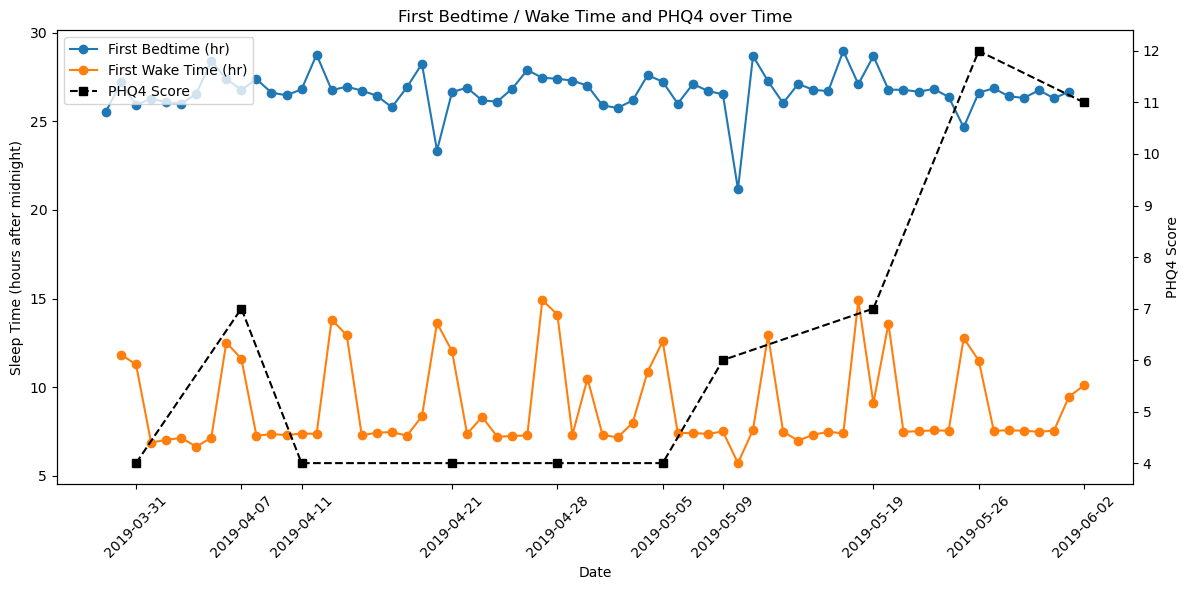

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Features to use
features_to_plot = {
    "bed": "f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday",
    "wake": "f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:allday"
}

# Merge features with PHQ4 scores
merged_df = pd.merge(
    pid_features_df[["date"] + list(features_to_plot.values())],
    pid_labels_df[["date", "phq4"]],
    on="date",
    how="left"
)

# Ensure datetime type for plotting and tick formatting
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Convert minutes to hours after midnight
merged_df["first_bed_hr"] = merged_df[features_to_plot["bed"]] / 60
merged_df["first_wake_hr"] = merged_df[features_to_plot["wake"]] / 60

# Sort by date to ensure consistent time series
merged_df = merged_df.sort_values("date")

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sleep features
ax1.plot(merged_df["date"], merged_df["first_bed_hr"], marker='o', label="First Bedtime (hr)")
ax1.plot(merged_df["date"], merged_df["first_wake_hr"], marker='o', label="First Wake Time (hr)")

ax1.set_xlabel("Date")
ax1.set_ylabel("Sleep Time (hours after midnight)")

# Restrict x-axis ticks to PHQ4 available dates
phq4_dates = merged_df.loc[merged_df["phq4"].notna(), "date"]
ax1.set_xticks(phq4_dates)
ax1.set_xticklabels(phq4_dates.dt.strftime('%Y-%m-%d'), rotation=45)

# PHQ4 scores on secondary axis
ax2 = ax1.twinx()
phq4_series = merged_df[["date", "phq4"]].dropna().sort_values("date")
ax2.plot(phq4_series["date"], phq4_series["phq4"], color='black', marker='s', linestyle='--', label='PHQ4 Score')
ax2.set_ylabel("PHQ4 Score")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("First Bedtime / Wake Time and PHQ4 over Time")
plt.tight_layout()
plt.show()


### Features list

** Features to plot first **

* f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday
* f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:allday
* f_slp:fitbit_sleep_summary_rapids_sumdurationinbedmain:allday
* f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday
* f_slp:fitbit_sleep_summary_rapids_lastbedtimemain:allday
* f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:allday
* f_slp:fitbit_sleep_summary_rapids_lastwaketimemain:allday


In [8]:
for c in pid_features_df.columns:
    print(c)

f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:afternoon
f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:afternoon
f_slp:fitbit_sleep_summary_rapids_sumdurationawakemain:afternoon
f_slp:fitbit_sleep_summary_rapids_sumdurationtofallasleepmain:afternoon
f_slp:fitbit_sleep_summary_rapids_sumdurationinbedmain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgdurationafterwakeupmain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgdurationawakemain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgdurationtofallasleepmain:afternoon
f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain:afternoon
f_slp:fitbit_sleep_summary_rapids_countepisodemain:afternoon
f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:afternoon
f_slp:fitbit_sleep_summary_rapids_lastbedtimemain:afternoon
f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:afternoon
f_slp:fitbit_sle